<a href="https://colab.research.google.com/github/AzadehHa/Data-Analytics/blob/main/ExamSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GROUP MEMBERS

1.   Azadeh Habibiandehkordi
2.   Bhakti Mendpara
3. Anjali Bankapur
4. Kalyani Kudalkar



Problem Statement: To determine if there is a statistically signi cant correlation between the price of Airbnb listings and the review rate
number. This will help us understand whether higher-priced listings are associated with better or worse reviews, which could give insights into
customer satisfaction.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/Airbnb_Open_Data.csv')

# Display the first few rows of the dataset
df.head()

# Checking for Missing Values
df.isnull().sum()

<ipython-input-2-9f5bf1aa1304>:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Airbnb_Open_Data.csv')


,0
id,0
NAME,250
host id,0
host_identity_verified,289
host name,406
neighbourhood group,29
neighbourhood,16
lat,8
long,8
country,532


1.Handle missing values and outliers.

In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    if df[col].isnull().any():
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)

categorical_cols = df.select_dtypes(exclude=['number']).columns
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

if df.isnull().any().any():
    print("There are still missing values in the dataset.")
else:
    print("There are no missing values in the dataset.")

There are no missing values in the dataset.


Justification:
We imputed the missing values with the mean for numerical columns and mode for categorical columns to preserve the dataset's size and minimize the impact of missing values on the analysis.



In [ ]:
# Checking for Outliers and removing them if there are any

def cap_outliers(df):
      for column in df.select_dtypes(include=['number']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

      print(f"Number of outliers: {len(column_outliers)}")
      return df

df_new = cap_outliers(df)

print("Cleaned Data:")
print(df_new.describe())

Number of outliers: 1
Cleaned Data:
                 id       host id            lat           long  \
count  1.025990e+05  1.025990e+05  102599.000000  102599.000000   
mean   2.914623e+07  4.925411e+10      40.728094     -73.949644   
std    1.625751e+07  2.853900e+10       0.055854       0.049519   
min    1.001254e+06  1.236005e+08      40.499790     -74.249840   
25%    1.508581e+07  2.458333e+10      40.688740     -73.982580   
50%    2.913660e+07  4.911774e+10      40.722290     -73.954440   
75%    4.320120e+07  7.399650e+10      40.762760     -73.932350   
max    5.736742e+07  9.876313e+10      40.916970     -73.705220   

       Construction year  minimum nights  number of reviews  \
count      102599.000000   102599.000000      102599.000000   
mean         2012.487464        8.135845          27.483743   
std             5.759540       30.492820          49.464781   
min          2003.000000    -1223.000000           0.000000   
25%          2008.000000        2.000000     

In [ ]:
df_new.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.210000,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,41662/AL
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.380000,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,41662/AL
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,6/23/2019,1.374022,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",41662/AL
3,1002755,Home away from home,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.640000,4.0,1.0,322.0,#NAME?,41662/AL
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.100000,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",41662/AL


2.Scale features using standardization or normalization.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# Select only numerical features for scaling
numerical_features = df_new.select_dtypes(include=['number']).columns
numerical_df = df_new[numerical_features]

#Standardization (Z-Score Scaling)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(numerical_df)
print("Standardized Data:\n", data_standardized)


Standardized Data:
 [[-1.73120763  1.07784182 -1.44311553 ...  0.56205328 -0.06020192
   1.07198843]
 [-1.73115546  0.10796022  0.45701471 ...  0.56205328 -0.18454718
   0.64279863]
 [-1.73113695  1.03631086  1.4488852  ...  1.34171467 -0.21563349
   1.56037681]
 ...
 [-1.4179792   0.69365856 -0.94968682 ...  1.34171467 -0.21563349
   1.48637857]
 [-1.41794525 -1.33479485  0.39023353 ... -0.21760811 -0.21563349
   1.81197083]
 [-1.41791124  0.66283389  0.71572461 ... -0.21760811 -0.21563349
  -0.53377338]]


Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


X = df_new[['price', 'availability 365', 'room type', 'neighbourhood group']].dropna()

# Created a binary target variable: High-rated (1) or Low-rated (0)
df_new['review_category'] = (df_new['review rate number'] >= 4).astype(int)

# features for classification
features = ['price', 'availability 365', 'room type', 'neighbourhood group']
target = 'review_category'

# Encoded categorical features using LabelEncoder
encoder = LabelEncoder()
df_new['room_type_encoded'] = encoder.fit_transform(df_new['room type'])
df_new['neighbourhood_group_encoded'] = encoder.fit_transform(df_new['neighbourhood group'])

# Prepared the final dataset with numeric features
X = df_new[['price', 'availability 365', 'room_type_encoded', 'neighbourhood_group_encoded']].dropna()
y = df_new.loc[X.index, target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train a Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)
accuracy, classification_report_output

(0.668648473034438,
 '              precision    recall  f1-score   support\n\n           0       0.69      0.72      0.70     16706\n           1       0.64      0.61      0.63     14074\n\n    accuracy                           0.67     30780\n   macro avg       0.67      0.66      0.66     30780\nweighted avg       0.67      0.67      0.67     30780\n')

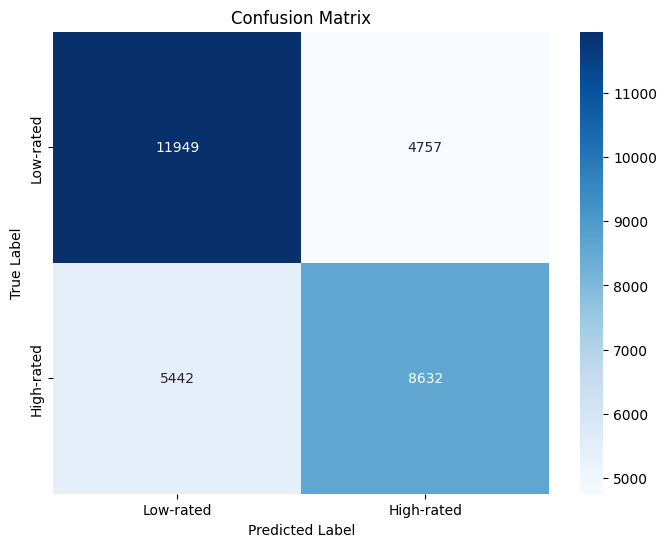

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low-rated', 'High-rated'], yticklabels=['Low-rated', 'High-rated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Justification:    
The classification model achieved an accuracy of **66.86%**, indicating moderate performance in predicting whether Airbnb listings are high-rated or low-rated based on features like price and availability. The precision, recall, and F1-score were higher for low-rated listings, suggesting the model is slightly more effective at identifying low-rated properties compared to high-rated ones. While the confusion matrix shows a balanced performance overall, it also highlights some degree of misclassification, leaving room for improvement in capturing high-rated listings accurately.

Clustering


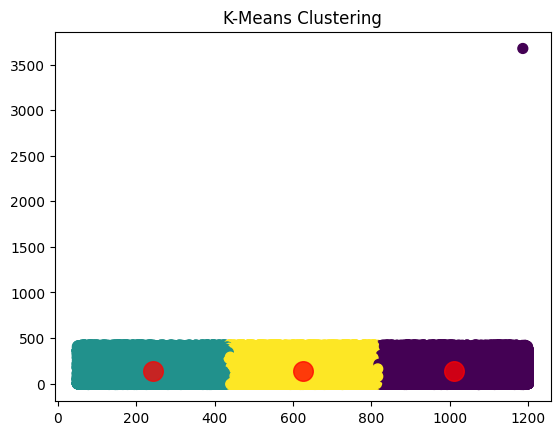

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import pandas as pd


# Prepare the final dataset with numeric features
X = df_new[['price', 'availability 365', 'room_type_encoded', 'neighbourhood_group_encoded']].dropna()
y = df_new.loc[X.index, target]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(X)

# Plot results
# Access the values of y directly, not as multi-dimensional data
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title("K-Means Clustering")
plt.show()

Justification:    
The classification approach using a Decision Tree is better than clustering in this case because it directly addresses the goal of predicting customer satisfaction, which is the primary objective. Unlike clustering, which groups data without predefined labels and requires additional interpretation, classification provides a clear, supervised framework that maps specific features (like price, availability, and room type) to the target variable (review rate). This results in measurable performance metrics such as accuracy, precision, and recall, allowing for more objective evaluation. Additionally, decision trees offer high interpretability, making it easier to understand and communicate how different features influence review ratings, which is essential for actionable business insights and decision-making.